In [864]:
from scipy.stats import boxcox
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format

## Сырые данные по РФ

In [865]:
# Пример данных
df = pd.read_csv('regional_data/infl_Российская_Федерация.csv')
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

y = df["inflation"] - 100

df.drop(['inflation', 'Date'], axis=1, inplace=True)

df.head(3)

,paid_services,salary,debt_firms,debt_fiz,fm_changes_volume,fm_changes_costs,fm_changes_demand,fm_demand_exp,fm_price_exp,Brent,MIACR,Infl_exp,M2,gov_debt,obligates
0,559456677.90,29535.00,18171671,9708233,-33.64,16.55,-19.00,17.86,13.97,108.12,6.06,13.04,31155.60,5722.24,6.20
1,571950883.80,29255.30,18184819,9821423,0.24,19.85,-5.42,20.61,16.51,108.90,5.99,11.80,29861.20,5733.57,6.39
2,591568267.20,31485.90,18458002,9964305,10.32,21.99,0.58,20.25,14.31,107.48,7.85,11.52,30169.00,5754.95,7.40


## Как выглядит распределение рядов без обработки

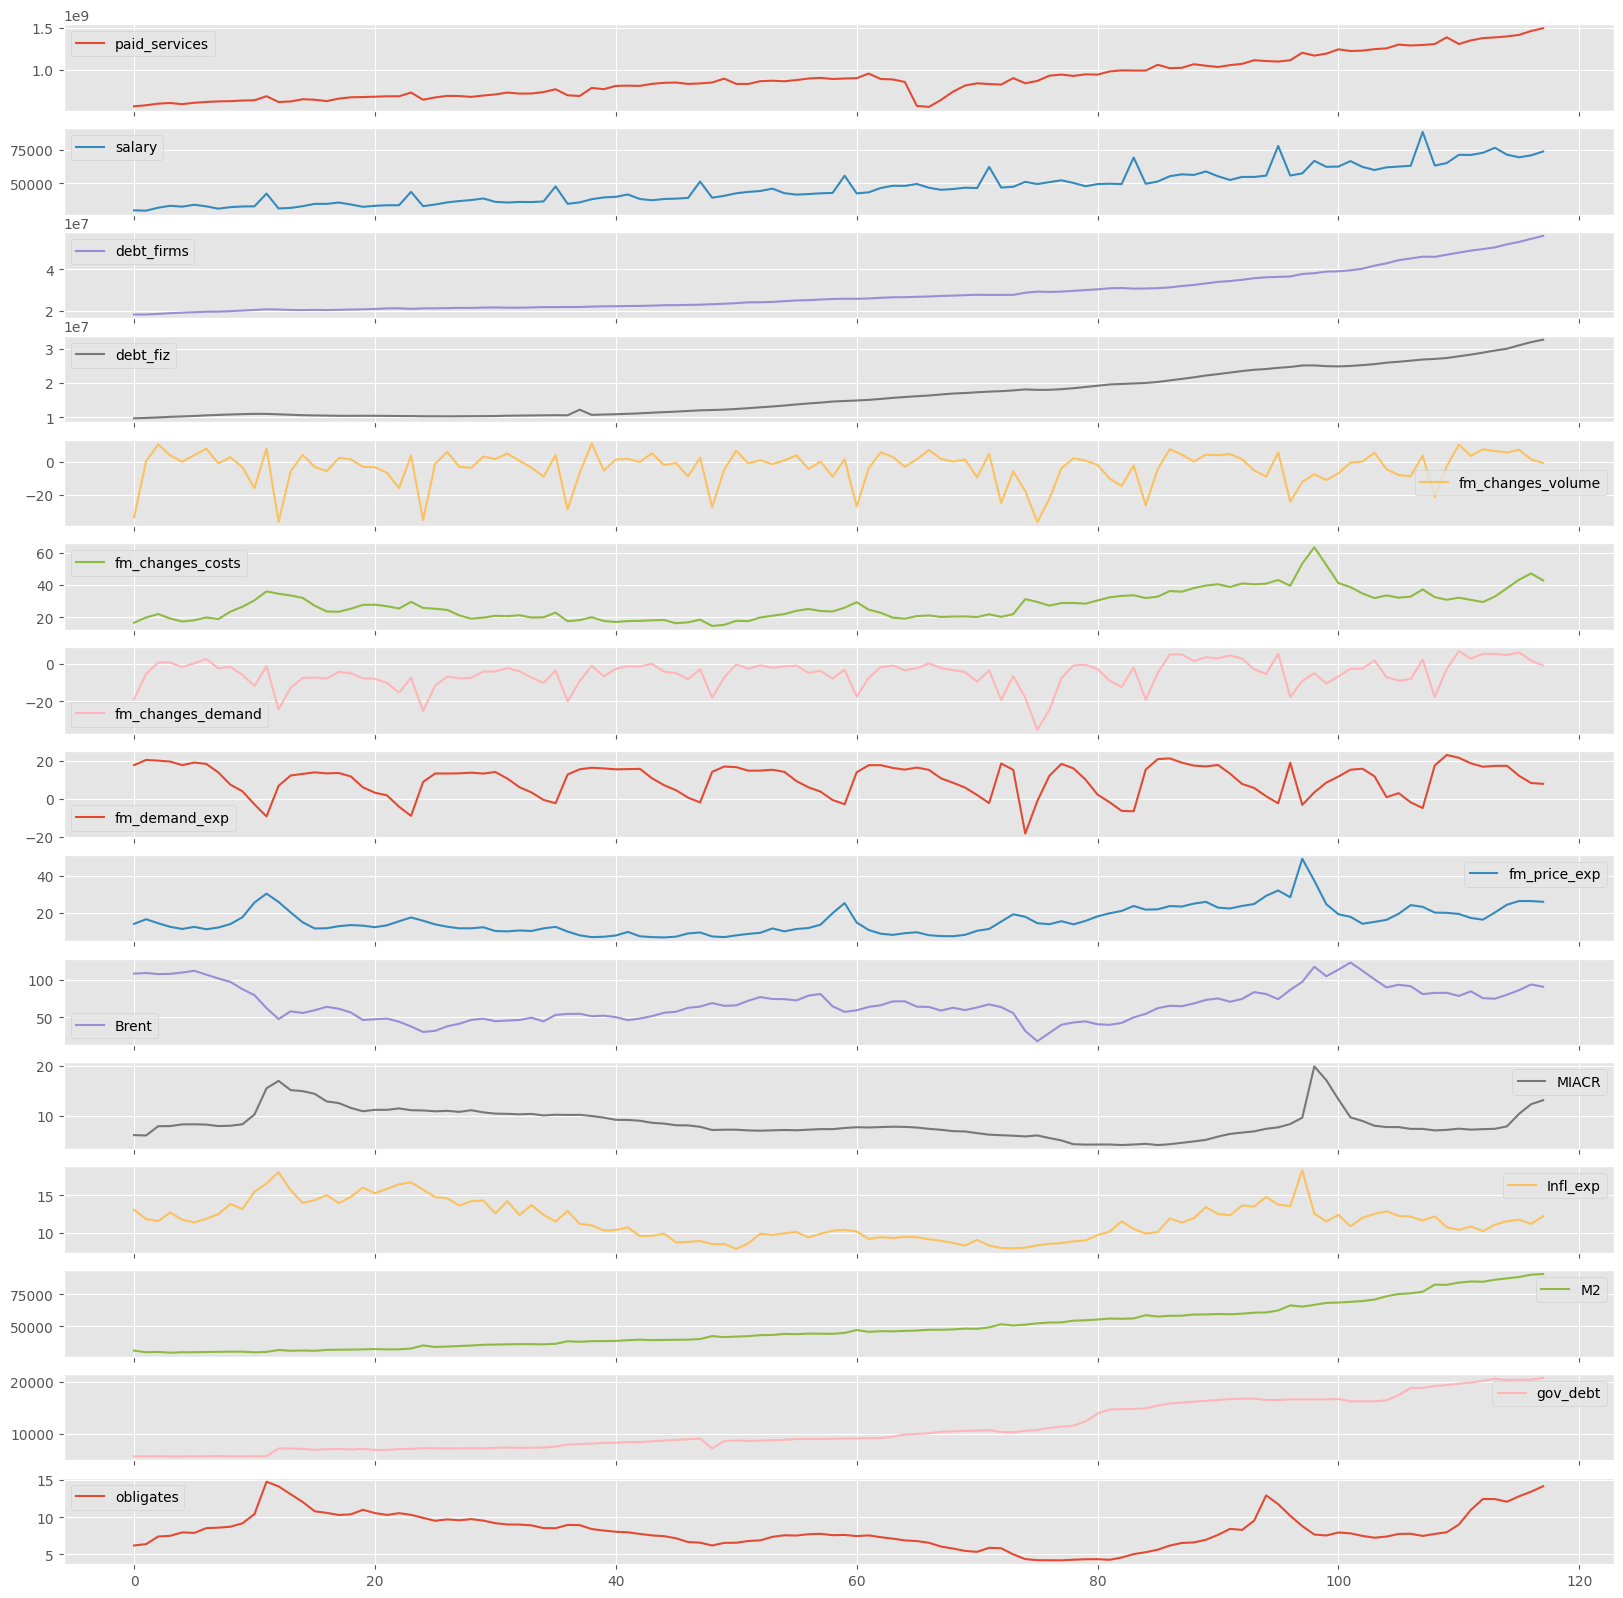

In [866]:
df.plot(kind='line', figsize=(20, 20), subplots=True);

## Находим ряды с большой размерностью / экспоненциальным ростом и применяем логарифмирование

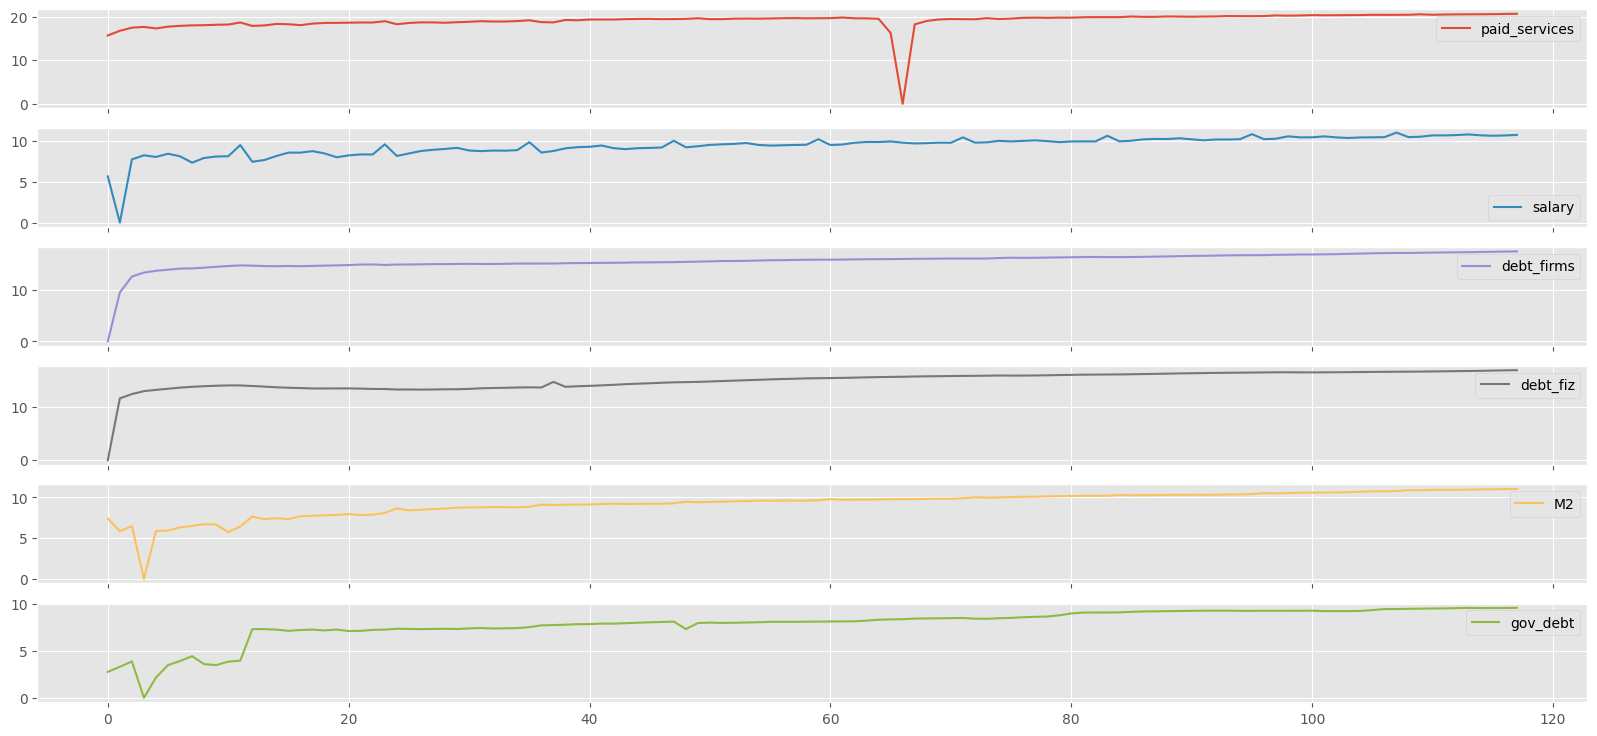

In [867]:
X_log = df[['paid_services', 'salary', 'debt_firms', 'debt_fiz', 'M2', 'gov_debt']].copy()
df.drop(['paid_services', 'salary', 'debt_firms', 'debt_fiz', 'M2', 'gov_debt'], axis=1, inplace=True)
X_log = X_log.apply(lambda x: np.log(x - x.min() + 1))
df = df.join(X_log)
X_log.plot(kind='line', figsize=(20, 9), subplots=True);

## Ищем ряды с ярко выраженной годовой сезонностью и применяем сезонную корректировку 

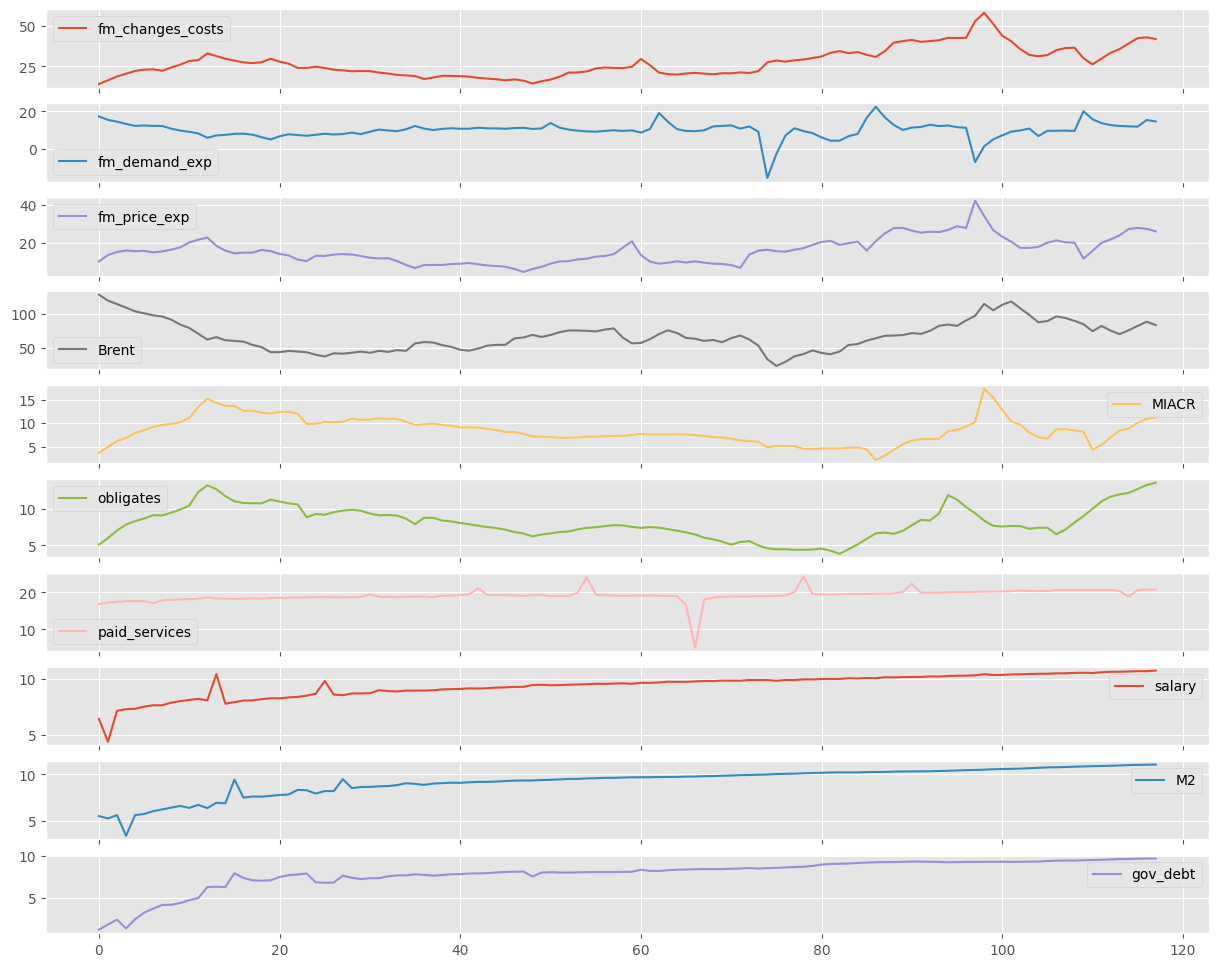

In [868]:
from statsmodels.tsa.seasonal import STL

df_season = df[['fm_changes_costs', 'fm_demand_exp', 'fm_price_exp', 'Brent', 'MIACR', 'obligates', 'paid_services', 'salary', 'M2', 'gov_debt']].copy()
df.drop(['fm_changes_costs', 'fm_demand_exp', 'fm_price_exp', 'Brent', 'MIACR', 'obligates', 'paid_services', 'salary', 'M2', 'gov_debt'], axis=1, inplace=True)
df_season = df_season.apply(lambda x: x - STL(x, period=12).fit().seasonal)
df = df.join(df_season)
df_season.plot(kind='line', figsize=(15, 12), subplots=True);

## Ищем ряды с регулярной сезонностью (каждые 2 месяца) и несколько раз удаляем сезонные факторы
#### В основном, это инфляционные ожидания

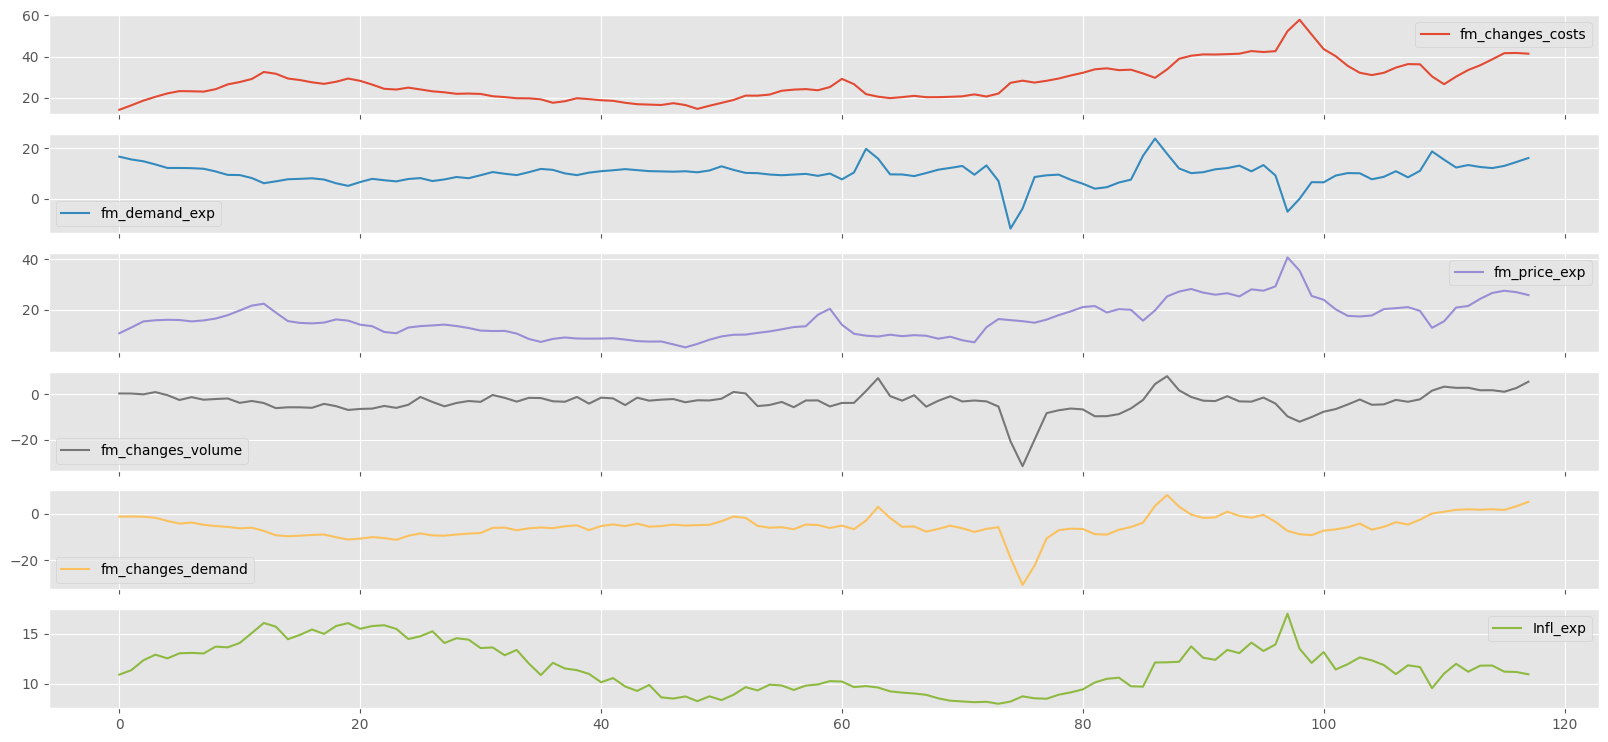

In [869]:
from statsmodels.tsa.seasonal import STL

df.columns
df_season_mstl = df[['fm_changes_costs', 'fm_demand_exp', 'fm_price_exp', 'fm_changes_volume', 'fm_changes_demand', 'Infl_exp']].copy()
df.drop(['fm_changes_costs', 'fm_demand_exp', 'fm_price_exp', 'fm_changes_volume', 'fm_changes_demand', 'Infl_exp'], axis=1, inplace=True)
df_season_mstl = df_season_mstl.apply(lambda x: x - STL(x, period=12).fit().seasonal)
df_season_mstl = df_season_mstl.apply(lambda x: x - STL(x, period=2).fit().seasonal)
df = df.join(df_season_mstl)
df_season_mstl.plot(kind='line', figsize=(20, 9), subplots=True);

## Берем первые разности и приводим ряды к 1 размерности

### Проверяем ряды на стационарность

In [870]:
df = df.diff(1).dropna()
df.apply(lambda x: adfuller(x)[1] < 0.05)


debt_firms            True
debt_fiz              True
Brent                False
MIACR                 True
obligates             True
paid_services         True
salary                True
M2                    True
gov_debt              True
fm_changes_costs      True
fm_demand_exp         True
fm_price_exp          True
fm_changes_volume     True
fm_changes_demand     True
Infl_exp              True
dtype: bool

## Итоговое распределение рядов

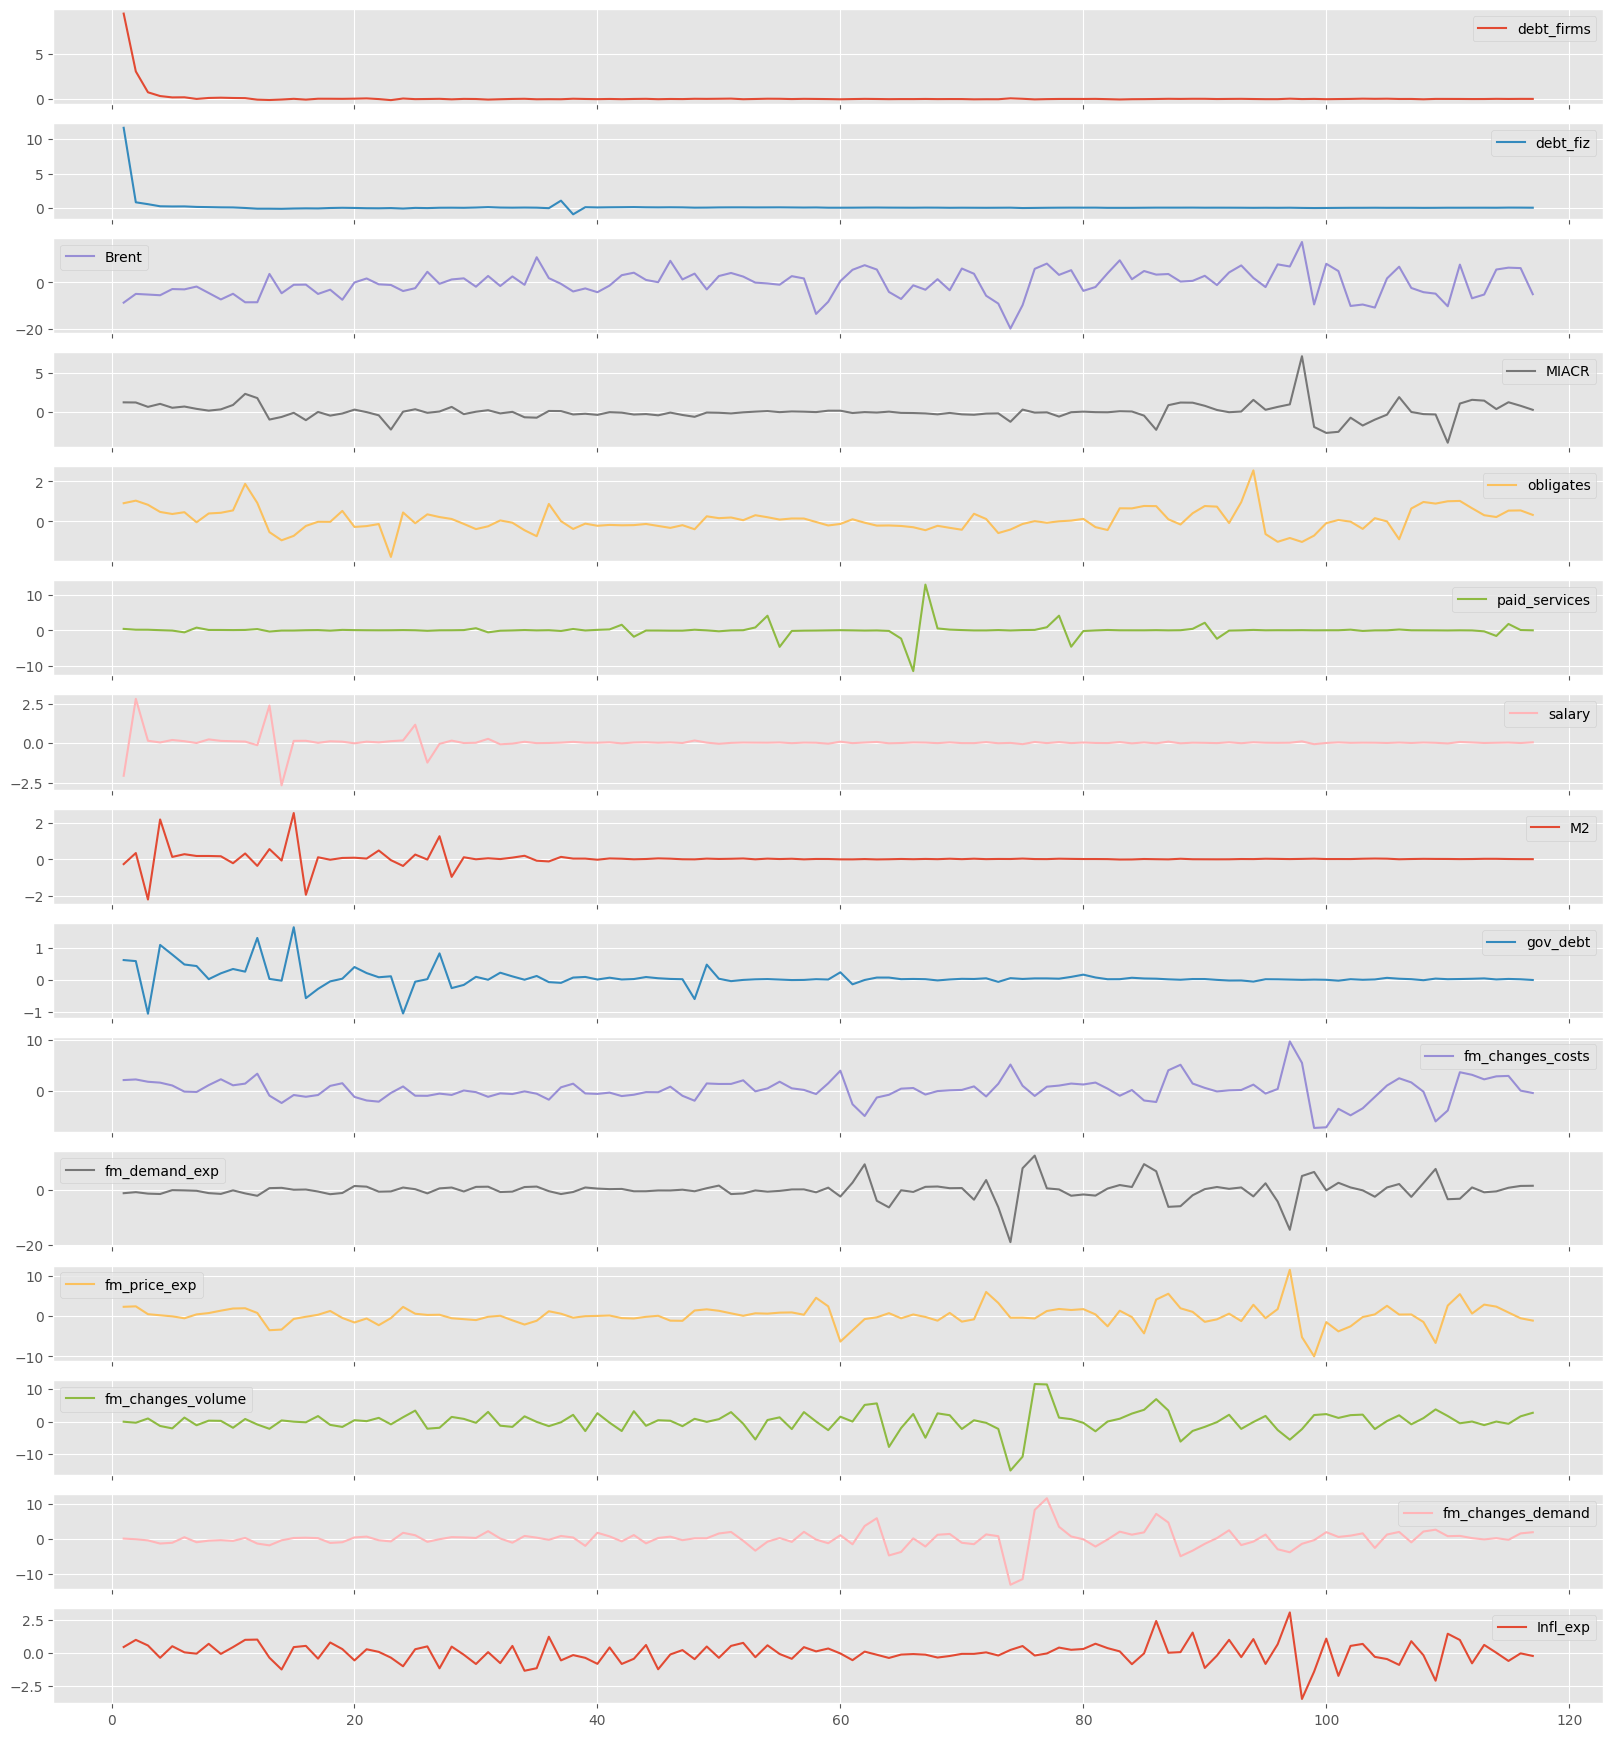

In [871]:
df.plot(kind='line', figsize=(20, 22), subplots=True);

## Применяем Метод главных компонент для переменных - опроссов коньюктуры рынка

### Формируем компоненты, объясняющие 90% дисперсии Х

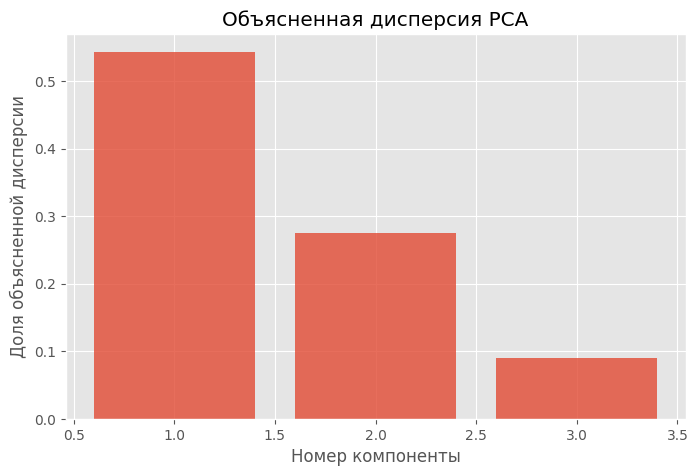

In [872]:
X_fm = df[['fm_changes_volume', 'fm_changes_costs', 'fm_changes_demand', 'fm_demand_exp', 'fm_price_exp']]
X = df.drop(columns=['fm_changes_volume', 'fm_changes_costs', 'fm_changes_demand', 'fm_demand_exp', 'fm_price_exp'])

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_fm)

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
loadings = pca.components_

# Визуализация объясненной дисперсии компонентами  PCA
plt.figure(figsize=(8, 5), dpi=100)
plt.bar(range(1, len(explained_variance) + 1),
        explained_variance, alpha=0.8, align='center')
plt.xlabel('Номер компоненты')
plt.ylabel('Доля объясненной дисперсии')
plt.title('Объясненная дисперсия PCA')
plt.show()

<Axes: >

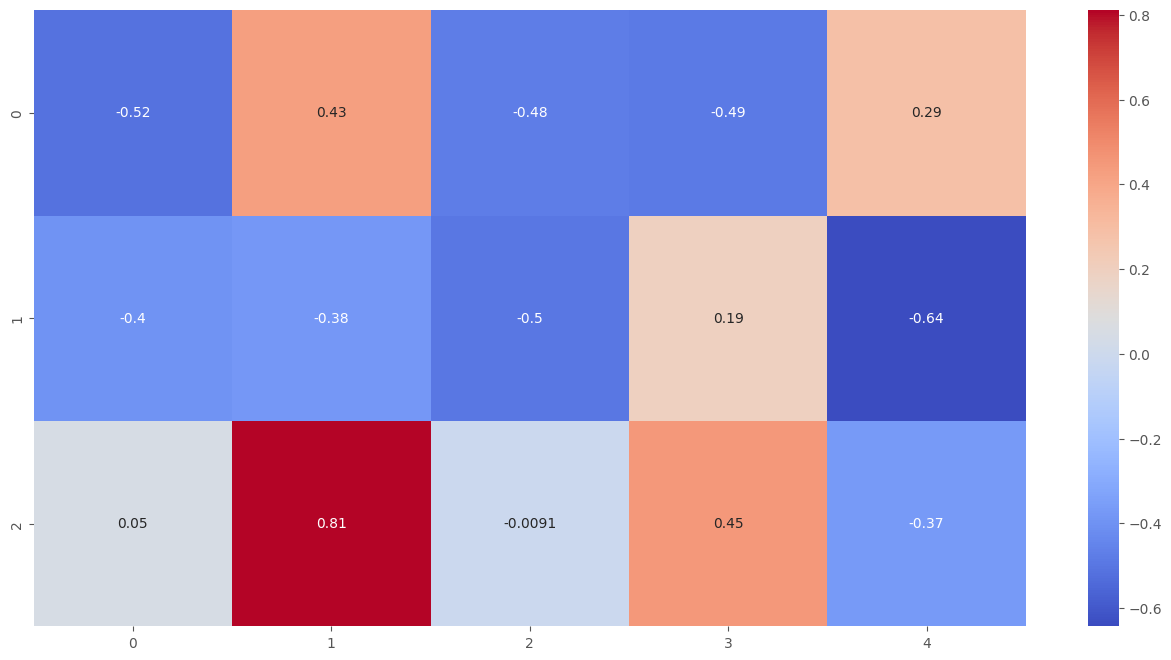

In [873]:
plt.figure(figsize=(16, 8))
sb.heatmap(loadings, annot=True, cmap='coolwarm')

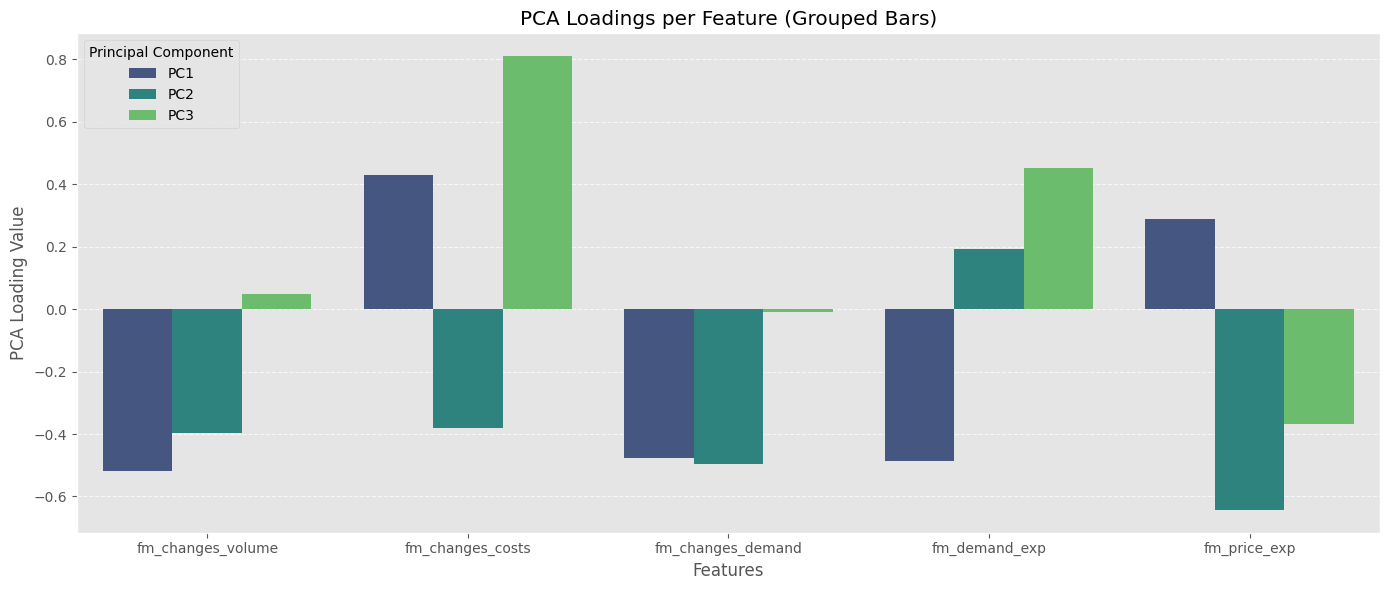

In [874]:
import seaborn as sns
import pandas as pd
feature_names = X_fm.columns
pc_names = [f'PC{i+1}' for i in range(pca.n_components_)]
# loadings_abs = np.abs(pca.components_)
loadings_abs = pca.components_


# Преобразуем loadings в DataFrame
loadings_df = pd.DataFrame(
    loadings_abs.T,  # Транспонируем, чтобы строки = признаки, столбцы = компоненты
    index=feature_names,
    columns=pc_names
).reset_index().melt(id_vars='index', var_name='PC', value_name='Loading')

# Переименуем колонки
loadings_df.columns = ['Feature', 'PC', 'Loading']

# Строим график
plt.figure(figsize=(14, 6))
sns.barplot(
    data=loadings_df,
    x='Feature',
    y='Loading',
    hue='PC',
    palette='viridis'
)

plt.title('PCA Loadings per Feature (Grouped Bars)')
plt.xlabel('Features')
plt.ylabel('PCA Loading Value')
plt.xticks( ha='center')
plt.legend(title='Principal Component', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [875]:
X_pca = pd.DataFrame(data=X_pca, columns=['PCA_1', 'PCA_2', 'PCA_3'])
X = X.join(X_pca).dropna()
X

,debt_firms,debt_fiz,Brent,MIACR,obligates,paid_services,salary,M2,gov_debt,Infl_exp,PCA_1,PCA_2,PCA_3
1,9.48,11.64,-8.74,1.25,0.91,0.43,-2.07,-0.26,0.62,0.45,0.84,-0.90,0.29
2,3.08,0.82,-4.95,1.24,1.03,0.19,2.80,0.35,0.59,0.99,0.45,-0.44,0.38
3,0.77,0.54,-5.23,0.68,0.83,0.18,0.15,-2.21,-1.06,0.56,0.93,0.10,0.31
4,0.35,0.24,-5.53,1.06,0.47,0.06,0.04,2.20,1.10,-0.37,0.68,0.38,0.31
5,0.20,0.21,-2.85,0.57,0.37,-0.06,0.19,0.14,0.80,0.51,-0.39,0.01,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.02,0.03,-6.86,1.57,0.66,-0.01,0.04,0.02,0.04,-0.79,1.03,-0.91,0.22
113,0.03,0.03,-5.22,1.47,0.31,-0.28,0.01,0.04,0.05,0.61,0.79,-1.06,0.56
114,0.04,0.03,5.62,0.40,0.22,-1.58,0.02,0.04,0.02,0.01,0.66,-0.45,0.96
115,0.03,0.05,6.43,1.27,0.54,1.82,0.03,0.02,0.03,-0.61,-0.83,-0.18,0.27


In [879]:
import os
os.makedirs('processed_regional_data', exist_ok=True)
os.path.join(os.getcwd(), 'processed_regional_data')

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/processed_regional_data'

In [880]:
df = X.join(y)
df.to_csv('processed_regional_data/infl_rus.csv', index=False)